# System configuration

In [1]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git

fatal: destination path 'explainability-challenges' already exists and is not an empty directory.


# Preamble

In [2]:
import sys
import torch
import numpy as np
import torchvision
import requests
sys.path.insert(1, "./explainability-challenges/src/")

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from torchvision import models

from torchvision.models import resnet50
from explainability.image.image_explanations import grad_cam, eigen_cam, guided_backprop

/opt/homebrew/Caskroom/miniconda/base/envs/10713/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
transform1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transform = torchvision.transforms.Compose([
     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
    ])


def huggingface_to_tensor(image_list):
    image_array_list = [transform1(image.convert('RGB')) for image in image_list]
    #image_array = np.stack(image_array_list, dim=0)

    return torch.stack(image_array_list)

In [19]:
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_idx = r.json()
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

def imagenet_classify(model, image):
    transform = torchvision.transforms.Compose([
     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
    ])

    idx = model(transform(img.unsqueeze(dim=0) / 255)).argmax()

    label = idx2label[idx]

    return label

In [4]:
dataset = load_dataset("frgfm/imagenette", "full_size", split="validation")
ood_dataset = huggingface_to_tensor(load_dataset("frgfm/imagewoof", "full_size", split="validation")['image'])
data_coco = huggingface_to_tensor(load_dataset("nielsr/coco-panoptic-val2017", split="train")['image'])

Found cached dataset imagenette (/Users/jrast/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
Found cached dataset imagewoof (/Users/jrast/.cache/huggingface/datasets/frgfm___imagewoof/full_size/1.0.0/27966bf439ec61d39fbb620b6c493290e3f75307ab7a7b4d979c61cfe5237a48)


# Exploring image explainability methods

In [6]:
def show_image(img):
    img = img.squeeze().permute(1,2,0)
    plt.imshow(img)

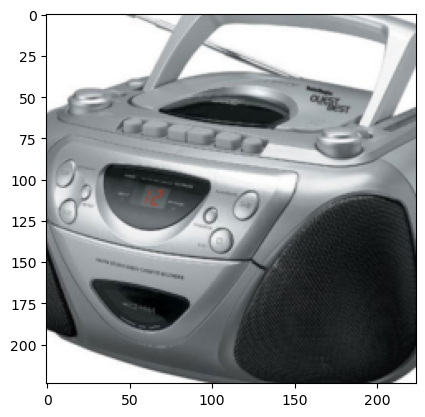

In [7]:
img = dataset[4]['image']
img = (transform1(img) * 255).int().float()

show_image(img / 255)

## Section 1: GradCAM

Class: cassette_player


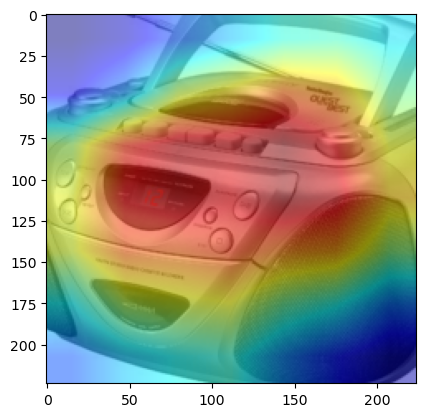

In [31]:
model = resnet50(pretrained=True).to('cpu')
visualization = grad_cam((img.unsqueeze(dim=0) / 255), model)

label = imagenet_classify(model, img)
print(f'Class: {label}')
plt.imshow(visualization)

## Section 2: Guided Backprop

In [33]:
# img = dataset[4]['image']
# img = (transform1(img) * 255).int().float()

In [40]:
model = models.alexnet(pretrained=True)
pos, neg = guided_backprop(transform(img.unsqueeze(dim=0) / 255), model)

In [43]:
# idx = model(transform(img.unsqueeze(dim=0) / 255)).argmax()
# label = idx2label[idx]
label = imagenet_classify(model, img)
print(f'Class: {label}')

Class: cassette_player


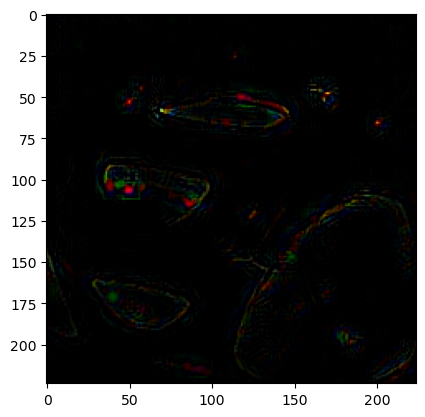

In [44]:
plt.imshow(np.moveaxis(pos.squeeze(), 0, 2))

## Section 3: EigenCAM

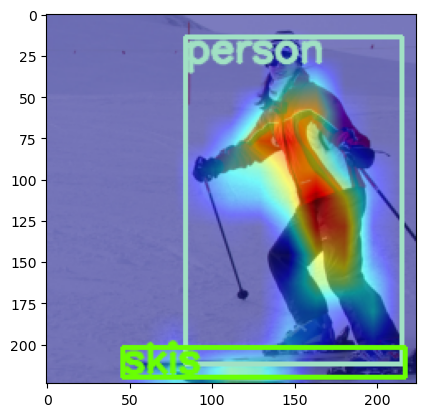

In [54]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to("cpu")

visualization = eigen_cam(data_coco[5] * 255, data_coco[5] * 255, model)
plt.imshow(visualization)